In [1]:
!pip install /pstore/home/shetabs1/code/iflai/

Defaulting to user installation because normal site-packages is not writeable
Processing /pstore/home/shetabs1/code/iflai
  Created wheel for iflai: filename=iflai-0.0.1-py3-none-any.whl size=25312 sha256=36a3a4d1af506dbca62f0bc03e99b72ff4b5a3ba122668ec3d020f99bc47c272
  Stored in directory: /local/3097519/pip-ephem-wheel-cache-hv_tn1uw/wheels/77/c9/46/be8aac478e8f67c427d0996a39b13c1213341ddb146b974964
Successfully built iflai
  Attempting uninstall: iflai
    Found existing installation: iflai 0.0.1
    Uninstalling iflai-0.0.1:
      Successfully uninstalled iflai-0.0.1
You should consider upgrading via the '/pstore/apps/Python/3.8.3-2020.07/bin/python -m pip install --upgrade pip' command.


In [2]:
import iflai
import matplotlib.pyplot as plt
import iflai.ml.Features as Features
from iflai.ml import AutoFeatureSelectionClassification
from iflai.ml.IntensityCorrection import IntensityCorrection
from iflai.ml.FeatureExtractor import FeatureExtractor 
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import h5py
from sklearn.pipeline import  FeatureUnion, Pipeline
from sklearn.feature_extraction import DictVectorizer
from iflai.utils import list_of_dict_to_dict
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns


In [3]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar

def classification_complete_report(estimator, X, y_true, labels = None ,plot = True ): 
    y_pred = estimator.predict(X)
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    if plot:
        plot_confusion_matrix(estimator, X, y_true, labels = labels ,cmap = "Greys", xticks_rotation='vertical')
    

In [4]:
data_path = "/pstore/data/DS4/synapse_formation_full_data/"

feature_union = FeatureUnion([
                                ("MaskBasedFeatures", Features.MaskBasedFeatures()), 
                                ("GLCMFeatures", Features.GLCMFeatures()),  
                                ("GradientRMS", Features.GradientRMS()),  
                                ("BackgroundMean", Features.BackgroundMean()), 
                                ("PercentileFeatures", Features.PercentileFeatures()), 
                                ("CellShape", Features.CellShape()),  
                                ("Collocalization", Features.Collocalization()),    
                                ("IntersectionProperties", Features.IntersectionProperties()),
                                ("CenterOfCellsDistances", Features.CenterOfCellsDistances())
]
)
# in_range = [   (743.3713,912.3604),
#                 (5.,39.9044),
#                 (43.6089,299.8445),
#                 (27.9951,471.6548),
#                 (37.4257,441.9936),
#                 (51.0297,423.2325),
#                 (39.3663,53.6433),
#                 (36.4257,138.0574),]

# out_range = [    (0,1.),
#                 (0,1.),
#                 (0,1.),
#                 (0,1.),
#                 (0,1.),
#                 (0,1.),
#                 (0,1.),
#                 (0,1.)]
# intensity_correction = IntensityCorrection(in_range=in_range, out_range= out_range  )
#("intensity_correction", intensity_correction) ,
pipeline = Pipeline([("features", feature_union)])

feature_extractor = FeatureExtractor(pipeline)

In [ ]:
# metadata = iflai.metadata_generator(data_path)

# metadata.to_csv("metadata.csv", index = False)

In [6]:
metadata = pd.read_csv("/pstore/home/shetabs1/data/synapse_data_features/metadata.csv")

In [7]:
all_combinations = metadata.groupby(["experiment", "donor", "condition"]).size().reset_index().iloc[:,:-1]
all_combinations

,experiment,donor,condition
0,Experiment_1,Donor_0,Not_Stimulated_Bcells
1,Experiment_1,Donor_1,+SEA
2,Experiment_1,Donor_1,-SEA
3,Experiment_1,Donor_1,Abatacept
4,Experiment_1,Donor_1,Isotype
...,...,...,...
62,Experiment_4,Donor_9,+SEA
63,Experiment_4,Donor_9,-SEA
64,Experiment_4,Donor_9,CD19-TCB
65,Experiment_4,Donor_9,DIG-TCB


,experiment,donor,condition
0,Experiment_1,Donor_0,Not_Stimulated_Bcells
1,Experiment_1,Donor_1,+SEA
2,Experiment_1,Donor_1,-SEA
3,Experiment_1,Donor_1,Abatacept
4,Experiment_1,Donor_1,Isotype
5,Experiment_1,Donor_1,Not_Stimulated_Tcells
6,Experiment_1,Donor_1,Teplizumab
7,Experiment_1,Donor_2,+SEA
8,Experiment_1,Donor_2,-SEA
9,Experiment_1,Donor_2,Abatacept


In [8]:

indx = metadata["set"] == "labeled"
for i in tqdm(range(len(all_combinations)), position=0, leave=True):
    if all_combinations.loc[i,"condition"] == "Not_Stimulated_Bcells":
        continue
    elif all_combinations.loc[i,"condition"] == "Not_Stimulated_Tcells":
        continue
    else:
        k = 15000
        indx_comb = (metadata["experiment"] == all_combinations.loc[i,"experiment"])
        indx_comb = indx_comb & (metadata["donor"] == all_combinations.loc[i,"donor"])
        indx_comb = indx_comb & (metadata["condition"] == all_combinations.loc[i,"condition"])
        indx_comb = indx_comb[indx_comb].sample(k).index.tolist()
        indx[indx_comb] = True

metadata = metadata.loc[indx,:].reset_index(drop = True).copy()

100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


In [44]:
all_combinations.head(20)

,experiment,donor,condition
0,Experiment_1,Donor_0,Not_Stimulated_Bcells
1,Experiment_1,Donor_1,+SEA
2,Experiment_1,Donor_1,-SEA
3,Experiment_1,Donor_1,Abatacept
4,Experiment_1,Donor_1,Isotype
5,Experiment_1,Donor_1,Not_Stimulated_Tcells
6,Experiment_1,Donor_1,Teplizumab
7,Experiment_1,Donor_2,+SEA
8,Experiment_1,Donor_2,-SEA
9,Experiment_1,Donor_2,Abatacept


In [9]:
columns = feature_extractor.extract_features(metadata.loc[0:1,:])[0].keys()
df_features = pd.DataFrame( columns= columns )

for com in all_combinations.index:
    indx = metadata["experiment"] == all_combinations.loc[ com,"experiment"]
    indx = indx&(metadata["donor"] == all_combinations.loc[ com,"donor"])
    indx = indx&(metadata["condition"] == all_combinations.loc[ com,"condition"])
    if indx.sum() > 0:
        features = feature_extractor.extract_features(metadata.loc[indx,:])
        df_features = df_features.append(pd.DataFrame(features), ignore_index = True )

100%|██████████| 15000/15000 [04:17<00:00, 58.36it/s]


In [10]:
df_features.shape

(817020, 1584)

In [11]:
metadata.shape

(817020, 7)

In [12]:
df_features = df_features.fillna(0.)
df_features = df_features.loc[:, df_features.std() > 0.]

In [13]:
set_of_interesting_classes = ['B_cell',  'T_cell', 
                        'T_cell_with_signaling',
                        'T_cell_with_B_cell_fragments',
                        'B_T_cell_in_one_layer',
                        'Synapses_without_signaling', 
                        'Synapses_with_signaling',
                        'No_cell_cell_interaction', 
                        'Multiplets'] 



labeled_index = metadata["label"].isin(set_of_interesting_classes)
labeled_index = labeled_index & metadata["condition"].isin(["-SEA","+SEA"])
metadata.loc[labeled_index ,"set"] = "train"
labeled_index.sum()

5221

In [14]:
from iflai.dl.util import train_validation_test_split

train_index = metadata["set"] == "train"
train_index = train_index[train_index].index

train_index, validation_index, test_index = train_validation_test_split(train_index, 
                                                                        metadata.loc[train_index,"label"],
                                                                        validation_size=0.20, 
                                                                        test_size=0.30)

metadata.loc[validation_index , "set"] = "validation"
metadata.loc[test_index , "set"] = "test"



In [15]:
## start here

In [16]:
df_features

,mask_based_area_Ch1,mask_based_bbox_area_Ch1,mask_based_convex_area_Ch1,mask_based_eccentricity_Ch1,mask_based_equivalent_diameter_Ch1,mask_based_euler_number_Ch1,mask_based_extent_Ch1,mask_based_feret_diameter_max_Ch1,mask_based_filled_area_Ch1,mask_based_major_axis_length_Ch1,...,cell_distance_Ch5_Ch7,weighted_cell_distance_Ch5_Ch7,cell_distance_Ch5_Ch8,weighted_cell_distance_Ch5_Ch8,cell_distance_Ch6_Ch7,weighted_cell_distance_Ch6_Ch7,cell_distance_Ch6_Ch8,weighted_cell_distance_Ch6_Ch8,cell_distance_Ch7_Ch8,weighted_cell_distance_Ch7_Ch8
0,885,1155,925,0.238094,33.568095,1,0.766234,36.138622,885,34.216438,...,3.942210,3.987281,-1.000000,-1.000000,0.0,0.260834,-1.000000,-1.000000,-1.000000,-1.000000
1,3176,4234,3334,0.716111,63.590949,1,0.750118,79.322128,3176,76.739910,...,-1.000000,-1.000000,2.116419,1.043671,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,2330,3078,2415,0.306409,54.466945,1,0.756985,59.405387,2330,56.171326,...,-1.000000,-1.000000,13.811253,12.106834,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,855,1056,880,0.386363,32.994239,1,0.809659,36.055513,855,34.395659,...,4.709238,4.426023,-1.000000,-1.000000,0.0,0.850990,-1.000000,-1.000000,-1.000000,-1.000000
4,756,891,777,0.607838,31.025298,1,0.848485,35.846897,756,34.968865,...,4.579343,4.687163,3.888689,3.510867,0.0,0.065744,1.270474,1.123749,1.270474,1.177918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817015,762,1218,822,0.894985,31.148171,1,0.625616,46.957428,762,47.086445,...,1.073140,1.264902,1.666642,1.847561,0.0,0.276795,1.926116,2.051873,1.926116,2.282219
817016,2768,3652,2906,0.867648,59.366043,1,0.757941,86.400231,2768,84.531415,...,-1.000000,-1.000000,23.826342,18.290893,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
817017,909,1073,928,0.622298,34.020211,1,0.847158,40.804412,909,38.830446,...,1.272254,1.722440,9.081763,9.332174,0.0,0.897813,8.060867,7.252616,8.060867,8.020618
817018,1017,1496,1112,0.606471,35.984505,1,0.679813,46.486557,1017,40.973828,...,8.147939,8.171864,0.943927,0.862327,0.0,0.169849,8.640317,8.746964,8.640317,8.618879


In [17]:
column_dict_rename = dict()

channel_names = {   
         "Ch1": "BF",
         "Ch2": "Antibody",
         "Ch3": "CD18",
         "Ch4": "F-Actin",
         "Ch5": "MHCII",
         "Ch6": "CD3",
         "Ch7": "P-CD3zeta",
         "Ch8": "Live-Dead"}

for col in df_features.columns:
    new_col = col
    for ch in channel_names:
        new_col = new_col.replace(ch,channel_names[ch] )
    column_dict_rename[col] = new_col
    
df_features = df_features.rename(columns=column_dict_rename).copy()

In [ ]:
df_features = df_features.drop(columns=[

 'sum_intensity_BF',
 'mean_intensity_BF',
 'std_intensity_BF',
 'kurtosis_intensity_BF',
 'skew_intensity_BF',
 'min_intensity_BF',
 'max_intensity_BF',
 'shannon_entropy_BF',
 'contrast_BF',
 'dissimilarity_BF',
 'homogeneity_BF',
 'ASM_BF',
 'energy_BF',
 'correlation_BF',
 'background_mean_BF',
 'correlation_distance_R1_BF_R2_Antibody',
       'euclidean_distance_R1_BF_R2_Antibody',
       'manders_overlap_coefficient_R1_BF_R2_Antibody',
       'intensity_correlation_quotient_R1_BF_R2_Antibody',
       'correlation_distance_R1_BF_R3_CD18',
       'euclidean_distance_R1_BF_R3_CD18',
       'manders_overlap_coefficient_R1_BF_R3_CD18',
       'intensity_correlation_quotient_R1_BF_R3_CD18',
       'correlation_distance_R1_BF_R4_F-Actin',
       'euclidean_distance_R1_BF_R4_F-Actin',
       'manders_overlap_coefficient_R1_BF_R4_F-Actin',
       'intensity_correlation_quotient_R1_BF_R4_F-Actin',
       'correlation_distance_R1_BF_R5_MHCII',
       'euclidean_distance_R1_BF_R5_MHCII',
       'manders_overlap_coefficient_R1_BF_R5_MHCII',
       'intensity_correlation_quotient_R1_BF_R5_MHCII',
       'correlation_distance_R1_BF_R6_CD3',
       'euclidean_distance_R1_BF_R6_CD3',
       'manders_overlap_coefficient_R1_BF_R6_CD3',
       'intensity_correlation_quotient_R1_BF_R6_CD3',
       'correlation_distance_R1_BF_R7_P-CD3zeta',
       'euclidean_distance_R1_BF_R7_P-CD3zeta',
       'manders_overlap_coefficient_R1_BF_R7_P-CD3zeta',
       'intensity_correlation_quotient_R1_BF_R7_P-CD3zeta',
       'correlation_distance_R1_BF_R8_Live-Dead',
       'euclidean_distance_R1_BF_R8_Live-Dead',
       'manders_overlap_coefficient_R1_BF_R8_Live-Dead',
       'intensity_correlation_quotient_R1_BF_R8_Live-Dead',
       'correlation_distance_R2_Antibody_R1_BF',
       'euclidean_distance_R2_Antibody_R1_BF',
       'manders_overlap_coefficient_R2_Antibody_R1_BF',
       'intensity_correlation_quotient_R2_Antibody_R1_BF',
       'correlation_distance_R3_CD18_R1_BF',
       'euclidean_distance_R3_CD18_R1_BF',
       'manders_overlap_coefficient_R3_CD18_R1_BF',
       'intensity_correlation_quotient_R3_CD18_R1_BF',
       'correlation_distance_R4_F-Actin_R1_BF',
       'euclidean_distance_R4_F-Actin_R1_BF',
       'manders_overlap_coefficient_R4_F-Actin_R1_BF',
       'intensity_correlation_quotient_R4_F-Actin_R1_BF',
       'correlation_distance_R5_MHCII_R1_BF',
       'euclidean_distance_R5_MHCII_R1_BF',
       'manders_overlap_coefficient_R5_MHCII_R1_BF',
       'intensity_correlation_quotient_R5_MHCII_R1_BF',
       'correlation_distance_R6_CD3_R1_BF',
       'euclidean_distance_R6_CD3_R1_BF',
       'manders_overlap_coefficient_R6_CD3_R1_BF',
       'intensity_correlation_quotient_R6_CD3_R1_BF',
       'correlation_distance_R7_P-CD3zeta_R1_BF',
       'euclidean_distance_R7_P-CD3zeta_R1_BF',
       'manders_overlap_coefficient_R7_P-CD3zeta_R1_BF',
       'intensity_correlation_quotient_R7_P-CD3zeta_R1_BF',
       'correlation_distance_R8_Live-Dead_R1_BF',
       'euclidean_distance_R8_Live-Dead_R1_BF',
       'manders_overlap_coefficient_R8_Live-Dead_R1_BF',
       'intensity_correlation_quotient_R8_Live-Dead_R1_BF',
       'sum_intensity_ratio_BF_R1_R2', 'mean_intensity_ratio_BF_R1_R2',
       'max_intensity_ratio_BF_R1_R2', 'sum_intensity_ratio_BF_R1_R3',
       'mean_intensity_ratio_BF_R1_R3', 'max_intensity_ratio_BF_R1_R3',
       'sum_intensity_ratio_BF_R1_R4', 'mean_intensity_ratio_BF_R1_R4',
       'max_intensity_ratio_BF_R1_R4', 'sum_intensity_ratio_BF_R1_R5',
       'mean_intensity_ratio_BF_R1_R5', 'max_intensity_ratio_BF_R1_R5',
       'sum_intensity_ratio_BF_R1_R6', 'mean_intensity_ratio_BF_R1_R6',
       'max_intensity_ratio_BF_R1_R6', 'sum_intensity_ratio_BF_R1_R7',
       'mean_intensity_ratio_BF_R1_R7', 'max_intensity_ratio_BF_R1_R7',
       'sum_intensity_ratio_BF_R1_R8', 'mean_intensity_ratio_BF_R1_R8',
       'max_intensity_ratio_BF_R1_R8'])

In [ ]:
more_columns_to_be_dropped = df_features.columns[(df_features.columns.str.contains( "intensity") & df_features.columns.str.contains( "BF"))]
df_features = df_features.drop(columns=more_columns_to_be_dropped)
more_columns_to_be_dropped = df_features.columns[(df_features.columns.str.contains( "percentile") & df_features.columns.str.contains( "BF"))]
df_features = df_features.drop(columns=more_columns_to_be_dropped)

In [18]:
metadata.to_csv("metadata_subset.csv", index = False)
df_features.to_csv("df_features.csv", index = False)

In [19]:
from sklearn import manifold, datasets
from sklearn import decomposition
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression,RidgeCV,PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR
 




In [20]:
classification_indx = ~df_features.columns.str.contains( "Antibody") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "Live-Dead") 
classification_indx = classification_indx& ~df_features.columns.str.contains( "CD18")  
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R2")  
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R3")  
classification_indx = classification_indx& ~df_features.columns.str.contains( "_R8")  

In [21]:
import random

xgb = Pipeline([
                ('StandardScaler', StandardScaler()), 
                ('AutoFeatureSelection', AutoFeatureSelectionClassification( top_k = 50 ,verbose=True)),
                 ('xgb', XGBClassifier(n_jobs = -1, n_estimators = 100, eval_metric = "logloss") )
], verbose=True)

xgb.fit(df_features.loc[train_index.tolist() + validation_index.tolist(), classification_indx],  
       metadata.loc[train_index.tolist() + validation_index.tolist(), "label"] )

f1_score(metadata.loc[test_index, "label"],
        xgb.predict(df_features.loc[test_index, classification_indx]), average='macro')


[Pipeline] .... (step 1 of 3) Processing StandardScaler, total=   0.0s
Step 1: Find highly correlated features
Step 2: wrapper methods
Calculating mutual information
Calculating SVC
Calculating random forest
Calculating l1 logistic regression
Calculating l2 logistic regression
Calculating xgb
number of similar features among all the methods: 0
From 578 initial features Selected (multicolinear): 184
Step 3: clustering over correlation of features
From 578 initial features Selected (uncorrelated): 50
[Pipeline]  (step 2 of 3) Processing AutoFeatureSelection, total=  42.6s
[Pipeline] ............... (step 3 of 3) Processing xgb, total=   1.7s


0.9214139703886663

In [ ]:
sns.set_style("white")
  
    

                              precision    recall  f1-score   support

                      B_cell       0.99      0.98      0.99       191
                      T_cell       0.91      0.94      0.92       200
       T_cell_with_signaling       0.90      0.85      0.88       149
T_cell_with_B_cell_fragments       0.93      0.94      0.94       188
       B_T_cell_in_one_layer       0.89      0.90      0.90       160
  Synapses_without_signaling       0.85      0.91      0.88       148
     Synapses_with_signaling       0.90      0.91      0.91       198
    No_cell_cell_interaction       0.95      0.93      0.94       180
                  Multiplets       0.95      0.93      0.94       153

                    accuracy                           0.92      1567
                   macro avg       0.92      0.92      0.92      1567
                weighted avg       0.92      0.92      0.92      1567

------------------------------------------------------------
matthews correlation coeff

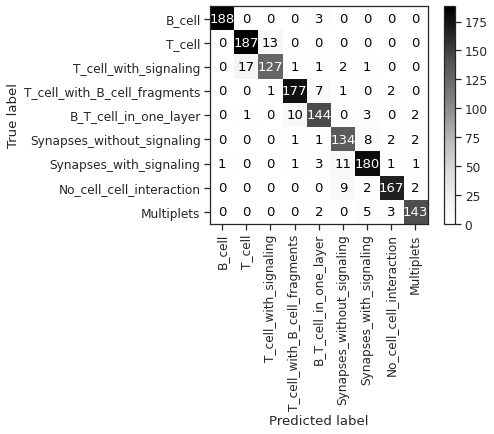

In [72]:
sns.set(font_scale = 1.1)
sns.set_style("ticks")
classification_complete_report(xgb, 
                               df_features.loc[test_index, classification_indx],
                               metadata.loc[test_index, "label"], labels = set_of_interesting_classes)

In [62]:
selected_features = xgb.steps[1][1].selected_features
selected_feature_names = df_features.columns[classification_indx][selected_features]
selected_feature_names

Index(['mask_based_eccentricity_BF', 'mask_based_equivalent_diameter_BF',
       'mask_based_extent_BF', 'mask_based_minor_axis_length_F-Actin',
       'mask_based_convex_area_MHCII', 'mask_based_euler_number_MHCII',
       'mask_based_extent_MHCII', 'mask_based_max_intensity_MHCII',
       'mask_based_eccentricity_CD3', 'mask_based_equivalent_diameter_CD3',
       'mask_based_mean_intensity_CD3', 'mask_based_max_intensity_P-CD3zeta',
       'mask_based_mean_intensity_P-CD3zeta',
       'mask_based_min_intensity_P-CD3zeta', 'contrast_BF',
       'dissimilarity_F-Actin', 'ASM_F-Actin', 'correlation_F-Actin',
       'contrast_MHCII', 'dissimilarity_MHCII', 'homogeneity_MHCII',
       'ASM_MHCII', 'homogeneity_CD3', 'contrast_P-CD3zeta',
       'energy_P-CD3zeta', 'background_mean_MHCII', 'background_mean_CD3',
       'background_mean_P-CD3zeta', 'percentile_10_F-Actin',
       'percentile_70_F-Actin', 'percentile_70_CD3', 'sum_intensity_MHCII',
       'sum_intensity_CD3', 'skew_intensity

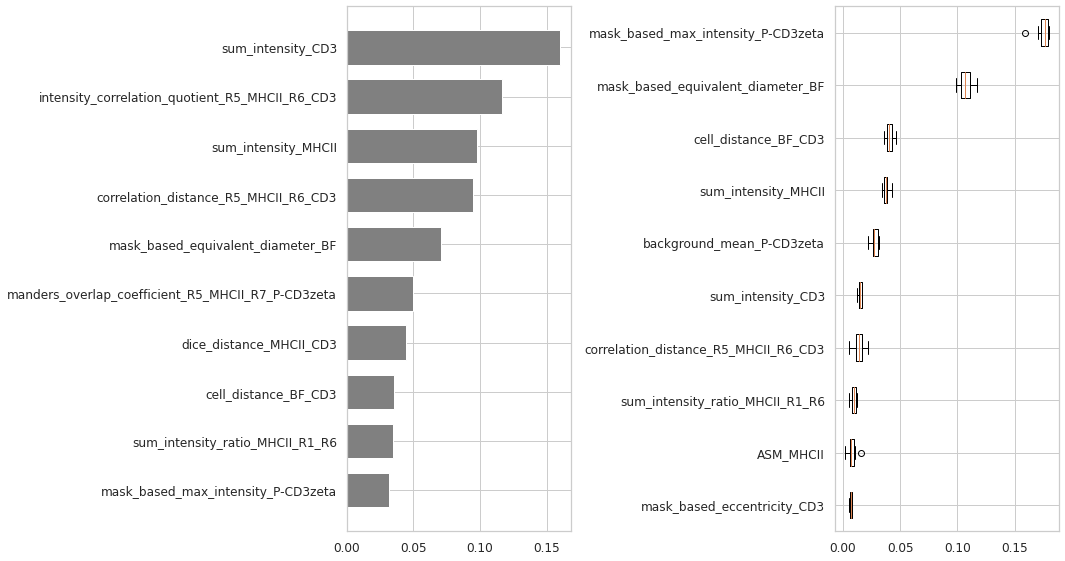

In [63]:
sns.set_style( "whitegrid" )

from sklearn.inspection import permutation_importance

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

tree_importance_sorted_idx = np.argsort(xgb.steps[2][1].feature_importances_)[-10:]

tree_indices = np.arange(0, 10) + 0.5

ax1.barh(tree_indices, 
         xgb.steps[2][1].feature_importances_[tree_importance_sorted_idx], 
         height=0.7, color  = "grey")
ax1.set_yticklabels(df_features.columns[classification_indx][selected_features].values[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)


result = permutation_importance(xgb, 
                                df_features.loc[test_index, classification_indx],
                                metadata.loc[test_index, "label"], 
                                n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()[-10:]
ax2.boxplot(result.importances[perm_sorted_idx].T, 
            vert=False,
            labels=df_features.columns[classification_indx].values[perm_sorted_idx])

fig.tight_layout()
#plt.savefig('Figure2/feature_importance.svg', bbox_inches="tight")

                              precision    recall  f1-score   support

                      B_cell       1.00      1.00      1.00        20
                      T_cell       0.70      0.91      0.79        23
       T_cell_with_signaling       0.92      0.75      0.83        32
T_cell_with_B_cell_fragments       0.93      0.96      0.95        28
       B_T_cell_in_one_layer       1.00      0.92      0.96        12
  Synapses_without_signaling       0.82      0.95      0.88        19
     Synapses_with_signaling       0.85      0.85      0.85        27
    No_cell_cell_interaction       0.88      0.93      0.90        15
                  Multiplets       1.00      0.77      0.87        22

                    accuracy                           0.88       198
                   macro avg       0.90      0.89      0.89       198
                weighted avg       0.90      0.88      0.88       198

------------------------------------------------------------
matthews correlation coeff

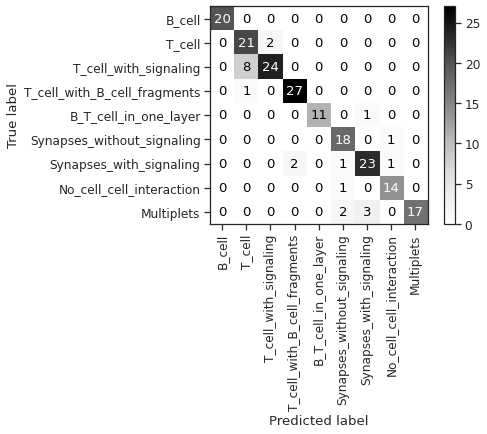

In [75]:

sns.set_style("ticks")
abatacept_test_index = metadata["label"].isin(set_of_interesting_classes)
abatacept_test_index = abatacept_test_index & metadata["condition"].isin(["Abatacept"])

classification_complete_report(xgb, 
                               df_features.loc[abatacept_test_index, classification_indx],
                               metadata.loc[abatacept_test_index, "label"], labels = set_of_interesting_classes)

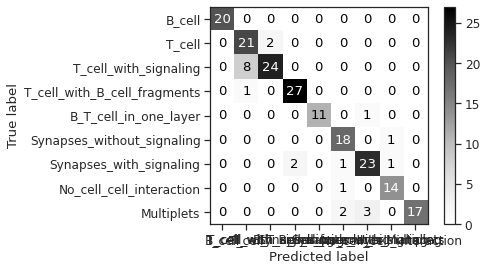

In [76]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

sns.set_style("ticks")
y_true = metadata.loc[abatacept_test_index, "label"]                      
y_pred = xgb.predict(df_features.loc[abatacept_test_index, classification_indx] ) 

cm = confusion_matrix(y_true, y_pred,labels= set_of_interesting_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set_of_interesting_classes)
disp.plot(cmap=plt.cm.Greys)
plt.savefig("/pstore/home/shetabs1/code/synapse_formation_paper/Final/Figure 1/confusion matrix abatacept.svg")

                              precision    recall  f1-score   support

                      B_cell       1.00      0.93      0.96        29
                      T_cell       0.66      1.00      0.79        23
       T_cell_with_signaling       1.00      0.73      0.85        45
T_cell_with_B_cell_fragments       0.97      0.92      0.94        36
       B_T_cell_in_one_layer       0.67      0.92      0.77        13
  Synapses_without_signaling       0.76      0.95      0.84        20
     Synapses_with_signaling       0.89      0.73      0.80        22
    No_cell_cell_interaction       1.00      0.96      0.98        27
                  Multiplets       0.73      0.67      0.70        12

                    accuracy                           0.87       227
                   macro avg       0.85      0.87      0.85       227
                weighted avg       0.90      0.87      0.87       227

------------------------------------------------------------
matthews correlation coeff

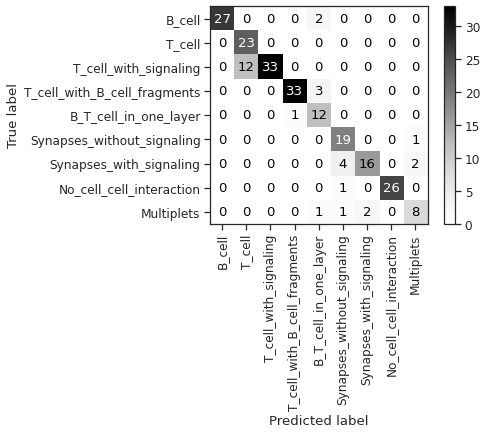

In [77]:

sns.set_style("ticks")
teplizumab_test_index = metadata["label"].isin(set_of_interesting_classes)
teplizumab_test_index = teplizumab_test_index & metadata["condition"].isin(["Teplizumab"])

classification_complete_report(xgb, 
                               df_features.loc[teplizumab_test_index, classification_indx],
                               metadata.loc[teplizumab_test_index, "label"], 
                               labels = set_of_interesting_classes)

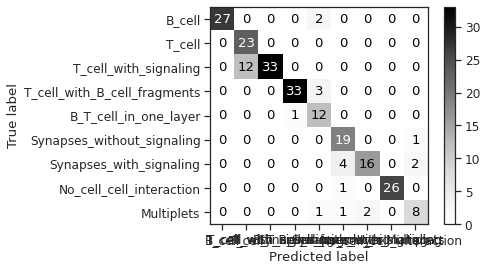

In [78]:
y_true = metadata.loc[teplizumab_test_index, "label"]                      
y_pred = xgb.predict(df_features.loc[teplizumab_test_index, classification_indx] ) 

sns.set_style("ticks")
cm = confusion_matrix(y_true, y_pred,labels= set_of_interesting_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set_of_interesting_classes)
disp.plot(cmap=plt.cm.Greys)
plt.savefig("/pstore/home/shetabs1/code/synapse_formation_paper/Final/Figure 1/confusion matrix teplizumab.svg")

In [79]:
teplizumab_test_index.sum()

227

                              precision    recall  f1-score   support

                      B_cell       0.98      1.00      0.99        50
                      T_cell       0.75      1.00      0.86        30
       T_cell_with_signaling       0.94      0.65      0.77        23
T_cell_with_B_cell_fragments       0.89      0.85      0.87        47
       B_T_cell_in_one_layer       0.87      0.91      0.89        45
  Synapses_without_signaling       0.77      0.87      0.82        23
     Synapses_with_signaling       0.93      0.87      0.90        77
    No_cell_cell_interaction       0.54      0.88      0.67         8
                  Multiplets       0.95      0.88      0.92        93

                    accuracy                           0.89       396
                   macro avg       0.85      0.88      0.85       396
                weighted avg       0.90      0.89      0.89       396

------------------------------------------------------------
matthews correlation coeff

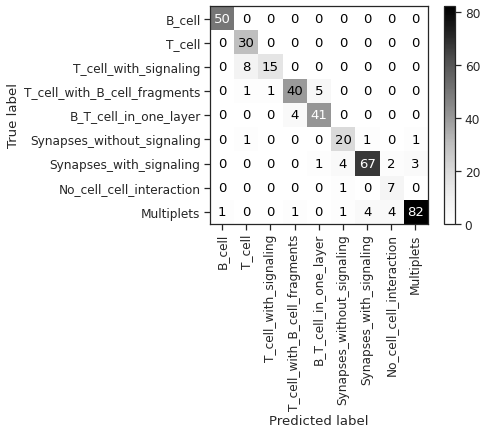

In [80]:

sns.set_style("ticks")
tcb_test_index = metadata["label"].isin(set_of_interesting_classes)
tcb_test_index = tcb_test_index & metadata["condition"].isin(["CD19-TCB"])

classification_complete_report(xgb, 
                               df_features.loc[tcb_test_index, classification_indx],
                               metadata.loc[tcb_test_index, "label"], labels = set_of_interesting_classes)

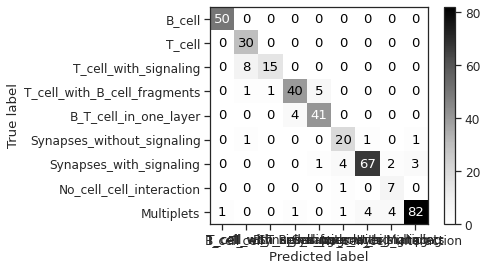

In [81]:
y_true = metadata.loc[tcb_test_index, "label"]                      
y_pred = xgb.predict(df_features.loc[tcb_test_index, classification_indx] ) 

sns.set_style("ticks")
cm = confusion_matrix(y_true, y_pred,labels= set_of_interesting_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set_of_interesting_classes)
disp.plot(cmap=plt.cm.Greys)
plt.savefig("/pstore/home/shetabs1/code/synapse_formation_paper/Final/Figure 1/confusion matrix tcb.svg")

In [82]:
metadata["condition"].unique()

array(['+SEA', '-SEA', 'Abatacept', 'Isotype', 'Teplizumab', 'CD19-TCB',
       'DIG-TCB'], dtype=object)

In [83]:
# df_features.memory_usage(index=True).sum()/1e9

In [ ]:
# metadata = pd.read_csv("/pstore/home/shetabs1/data/iflai/metadata_subset.csv")

In [ ]:
# all_combinations = metadata.groupby(["experiment", "donor", "condition"]).size().reset_index().iloc[:,:-1]
# all_combinations